配置环境

In [25]:
# 导入必要的库
import torch
import torch.nn as nn
import random
from torch.utils.data.dataloader import DataLoader
import numpy as np
from torch.optim.lr_scheduler import StepLR
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import *
from tools_np import *

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


# 设置随机数种子
setup_seed(27)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

定义超参数

In [26]:
# 定义超参数
input_size = 5 # 输入特征的维度
hidden_size = 100 # 隐藏层的维度
num_layers = 2 # BiLSTM 的层数
output_size = 1 # 输出的维度
batch_size = 5 # 批次大小
seq_len = 50 # 序列长度
learning_rate = 0.001 # 学习率
num_epochs = 30 # 训练轮数
train_length = 0.8 # 训练数据长度
step_size = 5 # 学习率变化周期
gamma = 0.5 # 学习率更新值

创建 dataset

In [27]:
dataset_1 = create_dataset(1)
dataset_2 = create_dataset(2)
dataset_3 = create_dataset(3)
dataset_4 = create_dataset(4)
dataset_5 = create_dataset(5)
dataset_6 = create_dataset(6)

分离训练集和测试集

In [28]:
# 将数据的前 train_length 的数据作为训练集 train_set
train_size_1 = int(dataset_1.shape[0] * train_length)
train_size_2 = int(dataset_2.shape[0] * train_length)
train_size_3 = int(dataset_3.shape[0] * train_length)
train_size_4 = int(dataset_4.shape[0] * train_length)
train_size_5 = int(dataset_5.shape[0] * train_length)
train_size_6 = int(dataset_6.shape[0] * train_length)


# 分离出训练集和测试集
train_1, test_1 = dataset_1[0:train_size_1], dataset_1[train_size_1:]
train_2, test_2 = dataset_2[0:train_size_2], dataset_2[train_size_2:]
train_3, test_3 = dataset_3[0:train_size_3], dataset_3[train_size_3:]
train_4, test_4 = dataset_4[0:train_size_4], dataset_4[train_size_4:]
train_5, test_5 = dataset_5[0:train_size_5], dataset_5[train_size_5:]
train_6, test_6 = dataset_6[0:train_size_6], dataset_6[train_size_6:]
train = np.concatenate((train_1, train_2, train_3, train_4, train_5, train_6), axis=0)
np.random.shuffle(train)

BiLSTM 模型

In [29]:
# 定义 BiLSTM 模型
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size) # 乘以2是因为双向的输出要拼接

    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 乘以2是因为双向的隐藏层要分开
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        # 通过 BiLSTM 层
        out, _ = self.bilstm(x, (h0, c0))
        # 取最后一个时间步的输出
        out = out[:, -1, :]
        # 通过全连接层
        out = self.fc(out)
        return out

# 创建模型实例
model = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)

# 定义损失函数和优化器
loss_function = nn.MSELoss()
loss_function = loss_function.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam 优化器
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

数据归一化

In [30]:
test_scaled = list()
scaler, train_scaled, test1_scaled = scale(train, test_1)
test_scaled.append(test1_scaled)
scaler, train_scaled, test2_scaled = scale(train, test_2)
test_scaled.append(test2_scaled)
scaler, train_scaled, test3_scaled = scale(train, test_3)
test_scaled.append(test3_scaled)
scaler, train_scaled, test4_scaled = scale(train, test_4)
test_scaled.append(test4_scaled)
scaler, train_scaled, test5_scaled = scale(train, test_5)
test_scaled.append(test5_scaled)
scaler, train_scaled, test6_scaled = scale(train, test_6)
test_scaled.append(test6_scaled)
dataset = DataPrepare(train_scaled) # 设置 inputs 和 labels
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=True)

训练模型

In [ ]:
# 训练模型
min_epochs = 10
best_model = None
min_loss = 1

for epoch in tqdm(range(num_epochs)):
    train_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.reshape(batch_size, 1, 5)

        # 梯度清零
        optimizer.zero_grad()
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)
        
        # 前向传播
        y_pred = model(inputs)
        
        # 计算损失
        loss = loss_function(labels, y_pred)
        train_loss.append(loss.cpu().item())
        
        # 更新梯度
        loss.backward()
        
        # 优化参数
        optimizer.step()
        
    scheduler.step()

    if epoch > min_epochs and loss < min_loss:
            min_val_loss = loss
            best_model = copy.deepcopy(model)

    print('epoch {} train_loss {:.8f}'.format(epoch, np.mean(train_loss)))
    model.train()

    torch.save(model, r'./result_np/Voltage_model_nopast.pth')

测试模型

In [ ]:
# 测试模型
test_num = 6 # 测试数据集选择
index = []
with torch.no_grad():
    model = torch.load("./result_np/Voltage_model_nopast.pth")
    print(model)
    
    # 预测测试数据
    print('Forecasting Testing Data')
    predictions_test = list() # 预测值
    expected = list() # 真实值
    test_dataset = DataPrepare(test_scaled[test_num-1]) # 分离 inputs 和 labels
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # 加载数据
    for i, data in enumerate(test_loader, 0):
        # make one-step forecast
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.reshape(batch_size, 1, 5)
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)

        # yhat 为预测值
        yhat = model(inputs)
        
        for j in range(yhat.shape[0]):
            yhat[j] = invert_scale(scaler, inputs[j].reshape(5, -1).cpu().numpy(), 
            yhat[j].cpu().detach().numpy())
            labels[j] = invert_scale(scaler, inputs[j].reshape(5, -1).cpu().numpy(),
            labels[j].cpu().detach().numpy())
            predictions_test.append(yhat[j].cpu().detach().numpy()) # 预测值序列
            expected.append(labels[j].cpu().detach().numpy()) # 真实值序列
        

    # RMSE 评价指标
    rmse_test = sqrt(mean_squared_error(np.array(expected) / 2, np.array(predictions_test) / 2))
    print('Test RMSE: %.3f' % rmse_test)

    # 保存输出结果
    index.append(rmse_test)
    with open(r'./result_np/voltage_prediction_result_test{}.txt'.format(test_num), 'a', encoding='utf-8') as f:
        for j in range(len(index)):
            f.write(str(index[j]) + " " + str(num_epochs) + " " + str(test_num) + "\n")
    with open(r'./result_np/voltage_prediction_data_test{}.txt'.format(test_num), 'a', encoding='utf-8') as f:
        f.write('test{}'.format(test_num) + "\n")
        for k in range(len(predictions_test)):
            f.write(str(predictions_test[k]) + "\n")

BiLSTM(
  (bilstm): LSTM(5, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)
Forecasting Testing Data
Test RMSE: 0.004


后处理

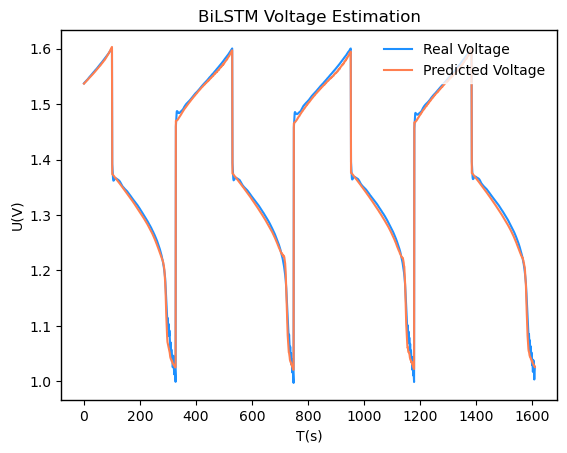

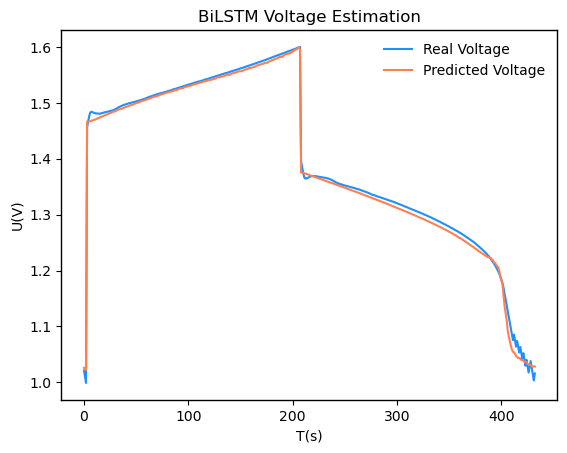

In [ ]:
# 绘制 Voltage 预测图像
# 创建横坐标
data_num = len(expected)
Cyc_X = np.linspace(0, data_num, data_num)
fig = plt.figure()
sub = fig.add_subplot(111) # 1*1 的网格中第一个图像
sub.plot(expected, c='dodgerblue', label='Real Voltage', linewidth=1.5)
sub.plot(predictions_test, c='coral', label='Predicted Voltage', linewidth=1.5)

# 设置坐标轴
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
plt.tick_params(labelsize=10) # 刻度标签字体大小
plt.legend(loc=1, edgecolor='w') # 创建图例
plt.ylabel('U(V)')
plt.xlabel('T(s)')
plt.title('BiLSTM Voltage Estimation')
plt.savefig(r'./result_np/Voltage_result_{}.png'.format(test_num))
plt.show()

# 绘制单次充放电循环电压输出预测
# 创建横坐标
start_index = [-612, -612, -532, -530, -553,-434]
end_index = [-1, -1, -1, -1, -1, -1]

data_num = len(expected[start_index[test_num-1]:end_index[test_num-1]])
Cyc_X = np.linspace(0, data_num, data_num)
fig = plt.figure()
sub = fig.add_subplot(111) # 1*1 的网格中第一个图像
sub.plot(expected[start_index[test_num-1]:end_index[test_num-1]], c='dodgerblue', label='Real Voltage', linewidth=1.5)
sub.plot(predictions_test[start_index[test_num-1]:end_index[test_num-1]], c='coral', label='Predicted Voltage', linewidth=1.5)

# 设置坐标轴
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
plt.tick_params(labelsize=10) # 刻度标签字体大小
plt.legend(loc=1, edgecolor='w') # 创建图例
plt.ylabel('U(V)')
plt.xlabel('T(s)')
plt.title('BiLSTM Voltage Estimation')
plt.savefig(r'./result_np/output_voltage_{}.png'.format(test_num))
plt.show()